In [1]:
import random
import gensim.matutils as gm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import numpy as np
from gensim import corpora, models
from tqdm import tqdm
from scipy.spatial.distance import cosine
from tqdm import tnrange as prange, tqdm_notebook as pbar
import copy
import sklearn
from sklearn.cross_validation import *
from collections import Counter
import pickle
import re
import pandas as pd
import scipy.stats as sps

# COLOR_GENERATOR

In [114]:
symbols = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
def color_generator():
    color = '#'
    for i in range(6):
        index = 0
        for j in range(1000) :
            index = random.randint(0, 15)
        color += (symbols[index])
    return color

In [117]:
UNIX_TIME = 1474275600

In [116]:
operators_number = [9,9,6,9,12] # Уберем из файлов первую строчку, равную кол-ву операторов

In [201]:
def make_all(office_number):
    data = pd.read_csv('/Users/semenfedotov/Desktop/Slupy/data/office_' + str(office_number), sep='\t')
    data = data.apply(lambda x: x - UNIX_TIME)
    
    bounds = [np.min(data['arrival_times']), np.max(data['start_service_time'])]
   
    #строим графики для времен прихода и обслуживания
    plt.figure(figsize=(17,5))
    for i in tqdm(range(len(data))):
        elem = data.iloc[i]
        plt.axhline(y=i, xmin=elem[0] / (bounds[1] - bounds[0]), xmax=elem[1] / (bounds[1] - bounds[0]), hold=None, color='red', alpha=0.5)
        plt.axhline(y=i, xmin=elem[1] / (bounds[1] - bounds[0]), xmax=elem[2] / (bounds[1] - bounds[0]), hold=None, color='green')
    plt.xlim(bounds[0], bounds[1])
    plt.ylim(-100, len(data) + 100)
    plt.plot(data['arrival_times'], range(len(data)), color=color_generator(), label='$arrival_times  CHART FOR $' + str(office_number) + ' OFFICE' )
    plt.legend(['waiting time','service time'])
    plt.legend()
    plt.show()
    
    # ОМП ДЛЯ экспоненциального распределения
    lambda_cup = 1 / np.mean(data['arrival_times'])
    
    arrival_time_max = np.max(data['arrival_times'])
    
    times_linspace = np.arange(0,arrival_time_max + 10, 1)
    
    #Построим Пуассоновский случайный процесс по экспоненциальным с.в.
    N_t = []
    for time in tqdm(times_linspace):
        N_t.append(np.sum([arr_time <= time for arr_time in data['arrival_times']]))

    plt.figure(figsize=(17,5))
    plt.plot(times_linspace, N_t, color=color_generator(), label='$N_t$')
    plt.legend()
    plt.show()
    
    %%time
    service_times = list(map(lambda ind: data['end_service_time'][ind] - data['start_service_time'][ind], range(len(data))))
   
    %%time
    plt.hist(service_times, color=color_generator())
    plt.show()
    
    %%time
    mean_service_time = np.mean(service_times)
    print('mean_service ', mean_service_time)
    
    
    # Узнаем с помощью ОМП оценку параметров гамма распределения
    fit_results = sps.gamma.fit(service_times)
    print('fit results : ', fit_results)
    
    
    
    #Строим доверительный интервал. Так как мы знаем распределение, то просто обе границы - квантили
    alpha = 1 - 0.05
    confint_bounds = []
    for time in tqdm(times_linspace):
        left = sps.poisson.ppf((1 - alpha) / 2., lambda_cup * time)
        right = sps.poisson.ppf((1 + alpha) / 2., lambda_cup * time)
        confint_bounds.append([left, right])
        
    confint_min_max = [np.min(np.array(confint_bounds)[:,0]), np.max(np.array(confint_bounds)[:,1])]
    confints_axis_len = confint_min_max[1] - confint_min_max[0]

    plt.fill_between(times_linspace, np.array(confint_bounds)[:,0], np.array(confint_bounds)[:,1], color = color_generator())
    plt.show()
    
    
    # Была идея строить не уровня доверия 1, как указано ниже, а на основе дов инта для N_t преобразовать нер-во, данное нам(для X_t), но получилось что-то неочень
    X_t_confint_with_N_t = []
    for time in tqdm(times_linspace):
        X_t_confint_with_N_t.append([N_t[time] - operators_number[office_number] * time / mean_service_time,
                            N_t[time] - operators_number[office_number] * (time - mean_service_time) / mean_service_time ])
    X_t_confint_with_N_t_min_max = [np.min(np.array(X_t_confint_with_N_t)[:,0]), np.max(np.array(X_t_confint_with_N_t)[:,1])]
    X_t_confints_with_N_t_axis_len = X_t_confint_min_max[1] - X_t_confint_min_max[0]

    plt.figure(figsize=(17,5))
    plt.fill_between(times_linspace, np.array(X_t_confint_with_N_t)[:,0], np.array(X_t_confint_with_N_t)[:,1], color = color_generator(), label='Confint for $X_t$')
    plt.legend()
    plt.show()    


    #пройдемся по сетке кол-ва операторов и добавим правые границы интервалов
    m_grid = range(1, 51)
    X_t_N_t_confint_m = []
    for  m in tqdm(m_grid):
        level_m = []
        for time in (times_linspace):
            level_m.append(N_t[time] - m * (time - mean_service_time) / mean_service_time)
        X_t_N_t_confint_m.append(level_m)
        
        
    cool_ms = []
    max_of_waiting_persons = []
    for m in tqdm(m_grid):
        max_of_waiting_persons.append(np.max(X_t_N_t_confint_m[m - 1]))
        if X_t_N_t_confint_m[m - 1][-20] >= X_t_N_t_confint_m[m - 1][-1]:
            cool_ms.append(m)
            
    plt.figure(figsize=(17,5))
    plt.plot(times_linspace, X_t_N_t_confint_m[operators_number[office_number]], color=color_generator(),label='confint for operators for $X_t$')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(17,5))
    plt.plot(m_grid, max_of_waiting_persons, color=color_generator())
    plt.show()
    
    
    min_operators = np.argmin(max_of_waiting_persons) + 1
    print( "Минимум достигается при количестве операторов равном(это и будет равно мин числу операторов): ", np.argmin(max_of_waiting_persons) + 1)
    
    
    
    #Не будем делать так, чтобы это выполнялось с вероятностью 1, а возбмем 0.95-квантиль 
#     quantiles_095 = []
#     for elem in tqdm(X_t_confint_m):
#         quantiles_095.append(np.percentile(elem ,95))
#     min_chairs = np.argmin(abs(np.array(quantiles_095))) + 1
    min_chairs = np.percentile(np.array(X_t_confint_with_N_t)[:,1], 95)
    print("Стульев надо столько: ", min_chairs)
#    4 = gg
    return N_t, X_t_confint_with_N_t, X_t_N_t_confint_m, m_grid, max_of_waiting_persons

100%|██████████| 617/617 [00:02<00:00, 274.23it/s]


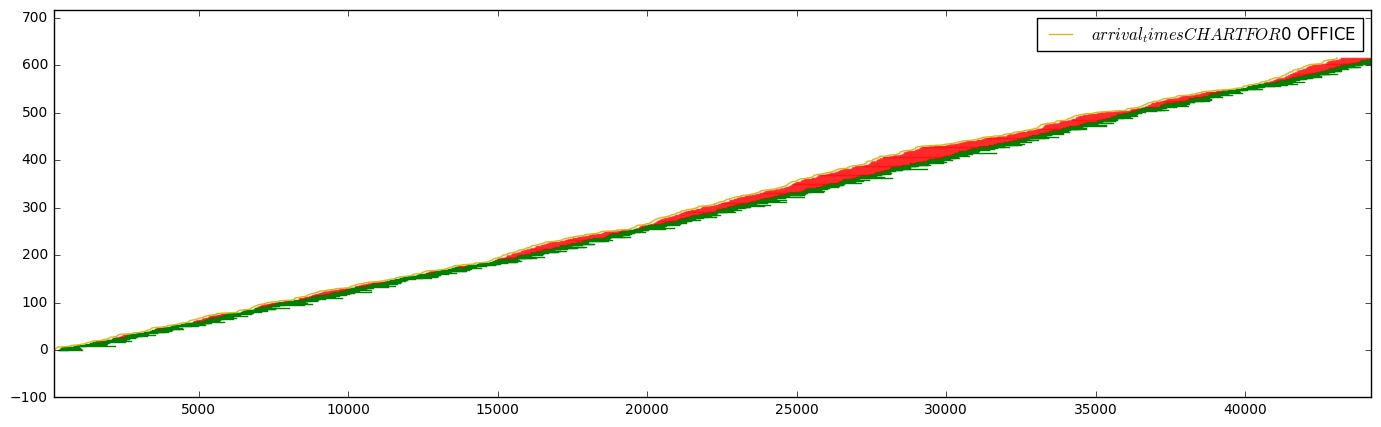

100%|██████████| 43072/43072 [00:08<00:00, 5145.19it/s]


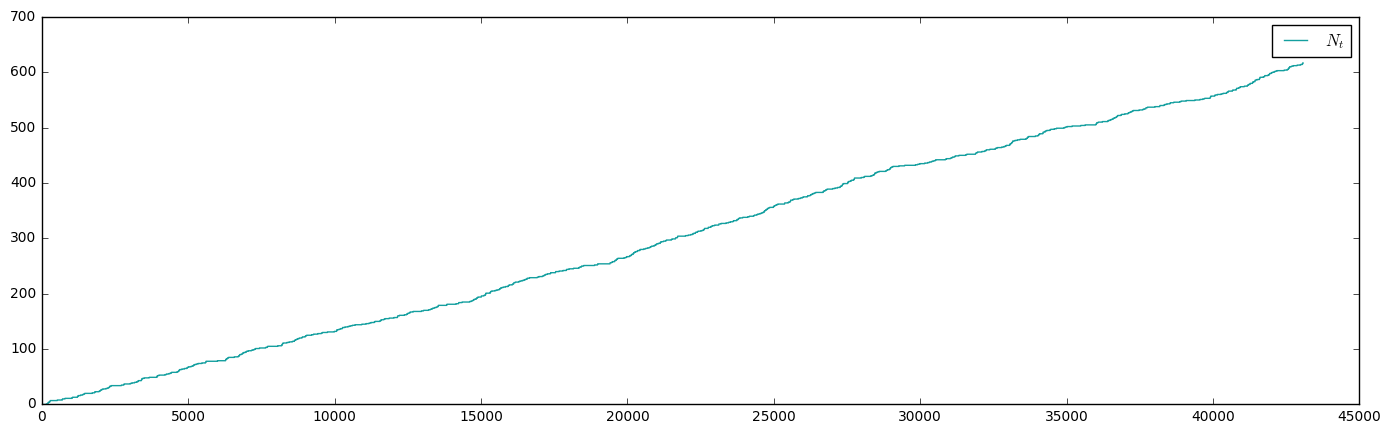

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


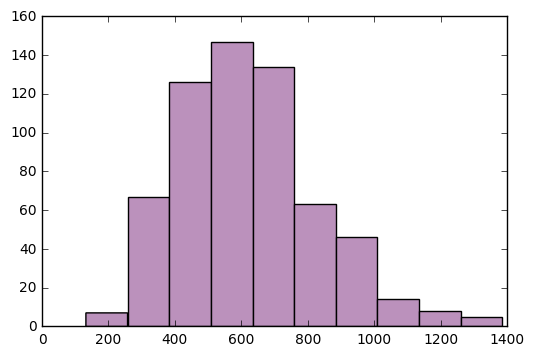

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 4.77 µs
mean_service  619.867098865


  2%|▏         | 732/43072 [00:00<00:11, 3800.15it/s]

fit results :  (8.3952299708195852, 10.879402100506228, 72.539728692237247)


100%|██████████| 43072/43072 [00:15<00:00, 2809.38it/s]


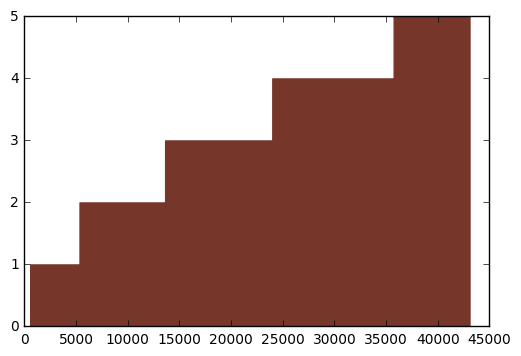

100%|██████████| 43072/43072 [00:00<00:00, 59098.11it/s]


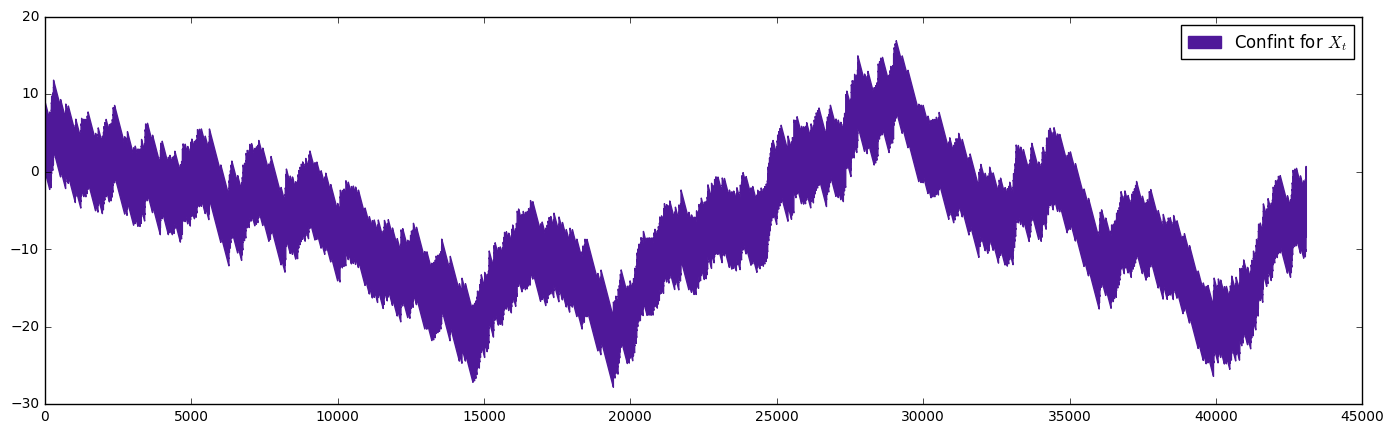

100%|██████████| 50/50 [00:00<00:00, 239.07it/s]


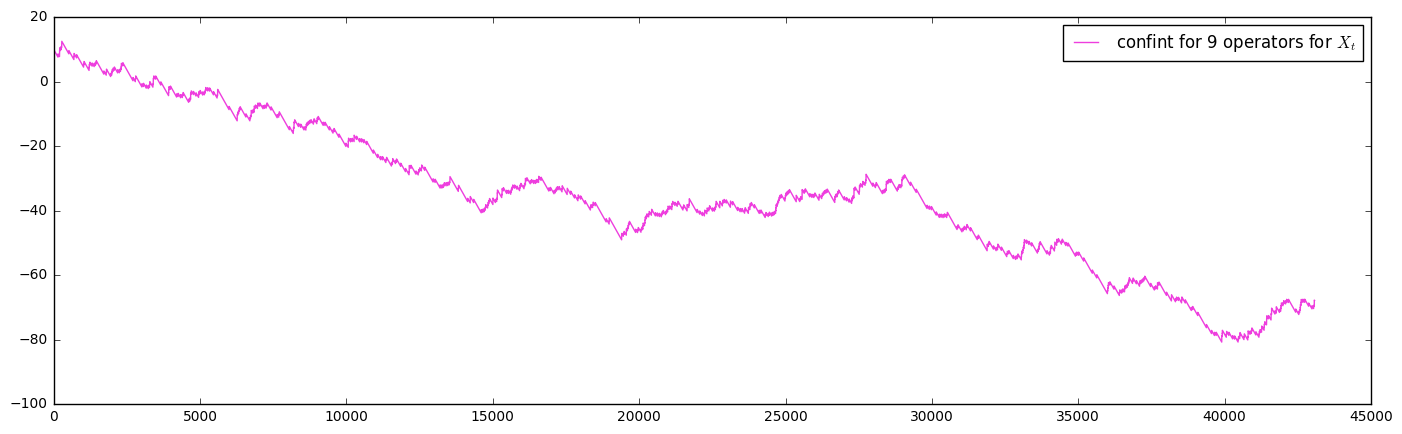

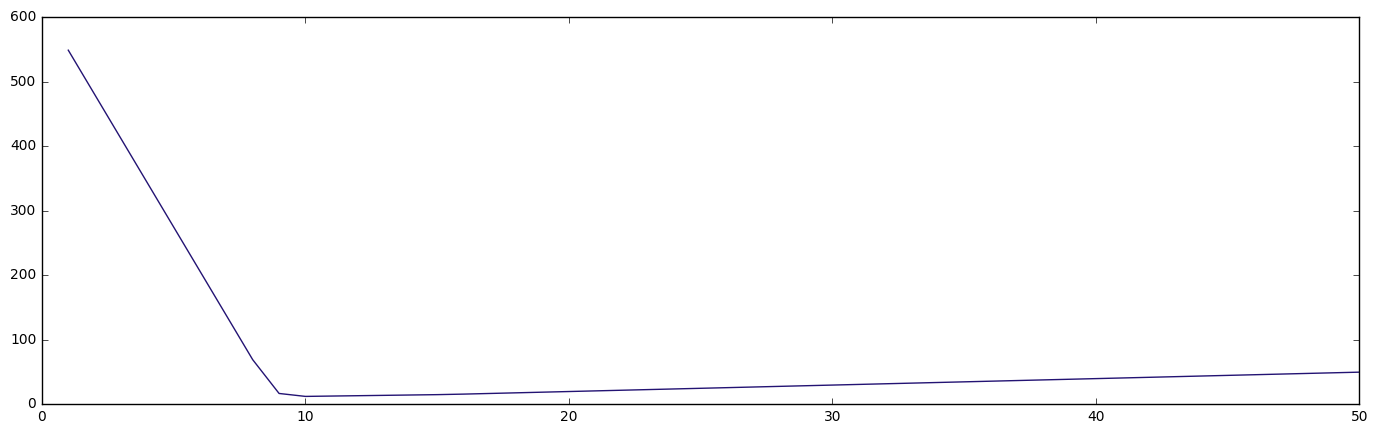

  6%|▋         | 23/357 [00:00<00:01, 224.04it/s]

Минимум достигается при количестве операторов равном(это и будет равно мин числу операторов):  10
Стульев надо столько:  10.5408923333
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
 ^^^^^^^^^^^^^^^^^^^^^^^^^NEW OFFICE NUMBER 1^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-

100%|██████████| 357/357 [00:00<00:00, 395.73it/s]


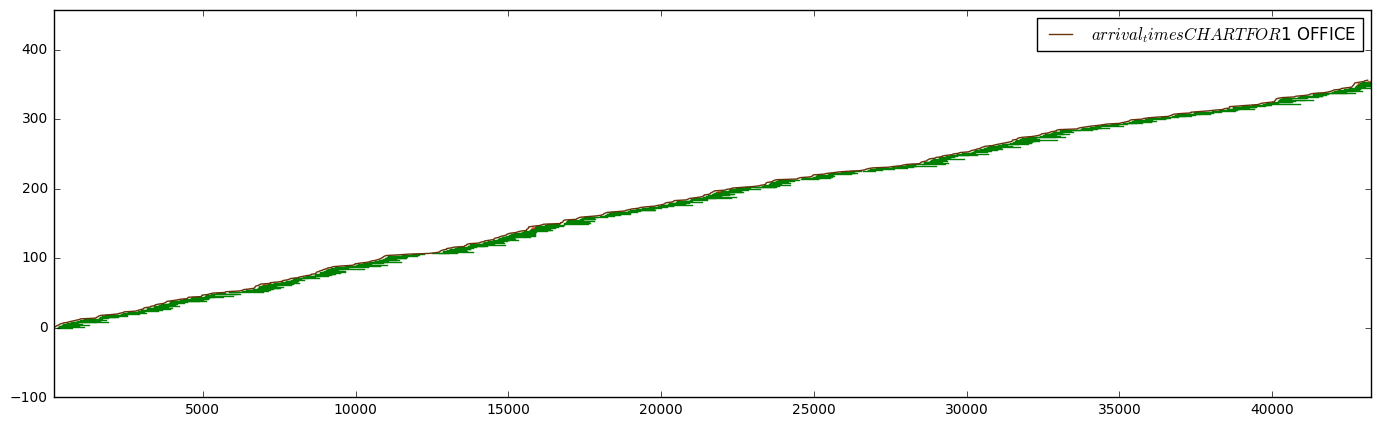

100%|██████████| 43137/43137 [00:03<00:00, 11570.86it/s]


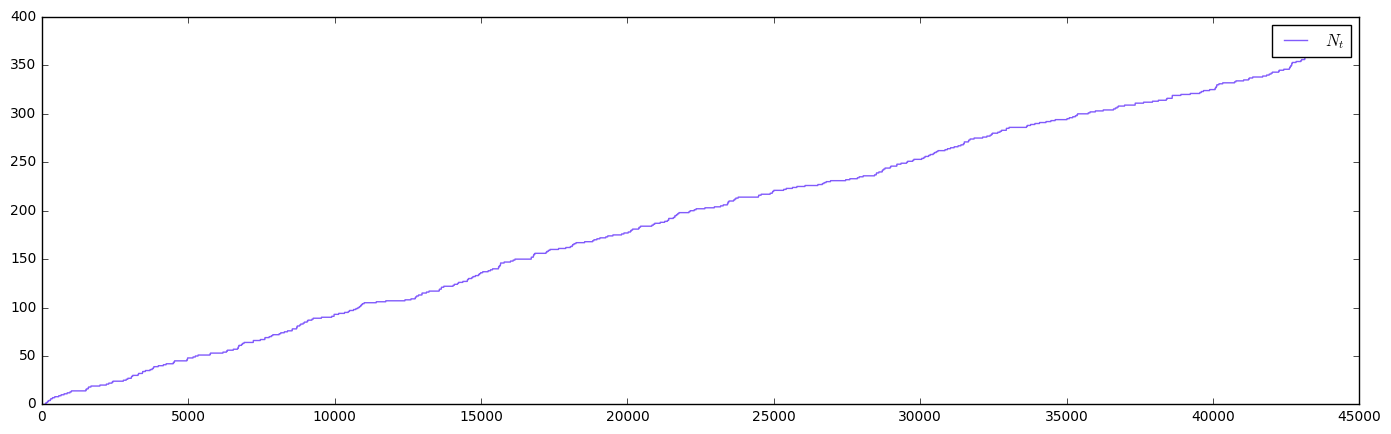

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


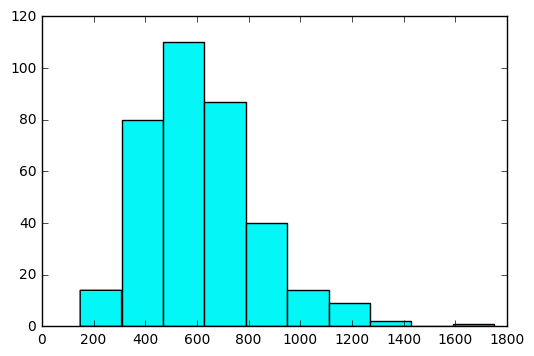

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
mean_service  617.014005602


  2%|▏         | 834/43137 [00:00<00:10, 4164.46it/s]

fit results :  (7.1754784989687241, 36.118949904235016, 80.955584933388778)


100%|██████████| 43137/43137 [00:10<00:00, 4227.85it/s]


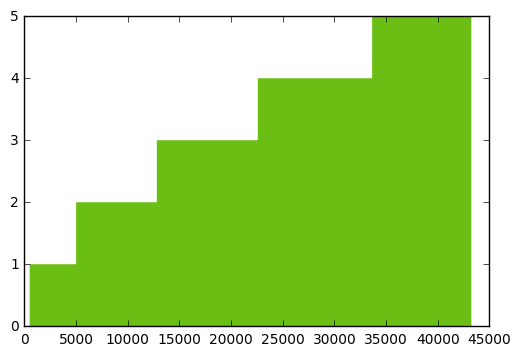

100%|██████████| 43137/43137 [00:00<00:00, 97378.47it/s]


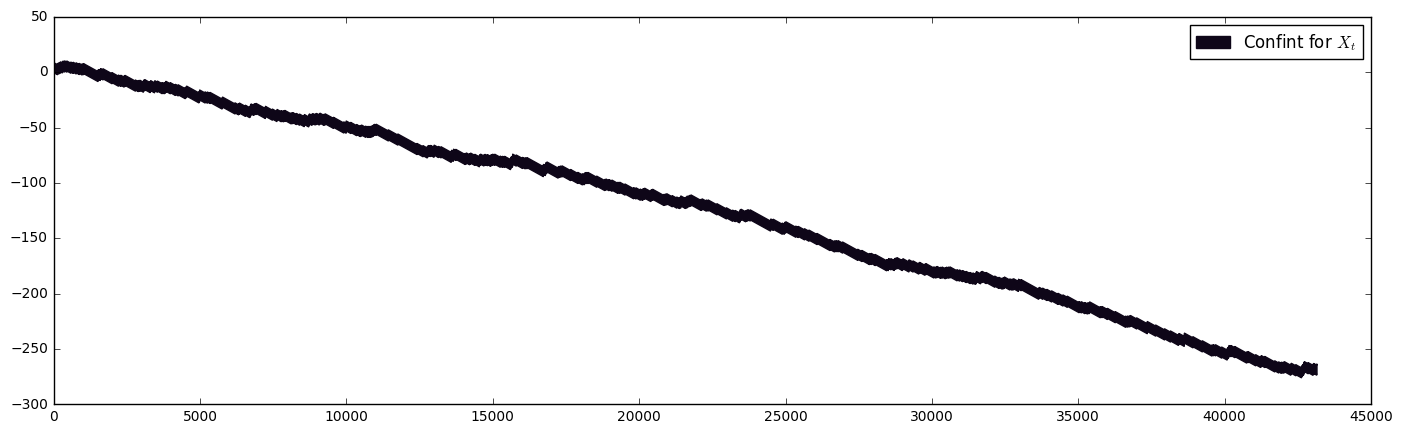

100%|██████████| 50/50 [00:00<00:00, 281.61it/s]


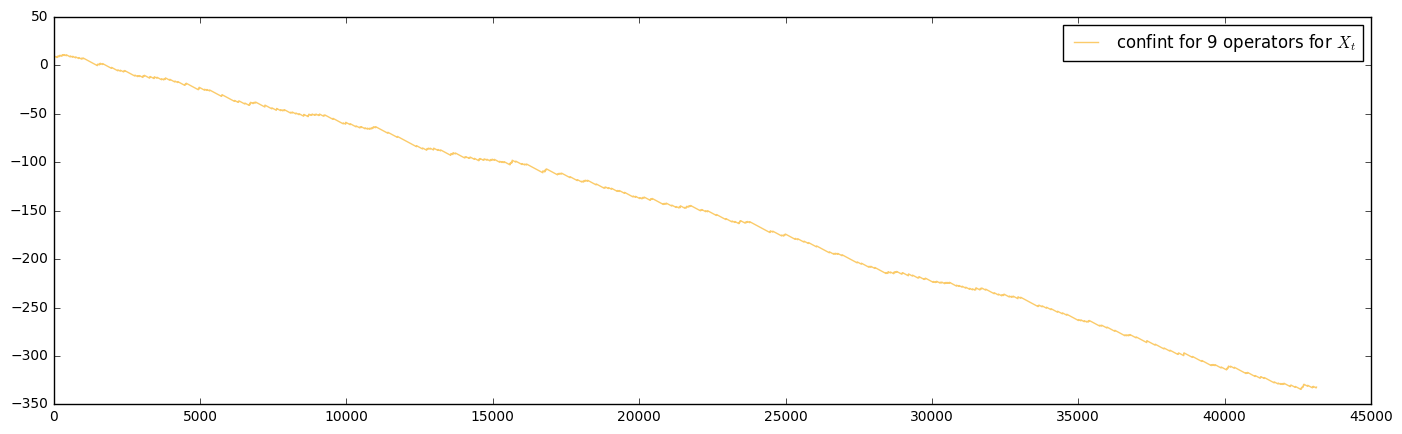

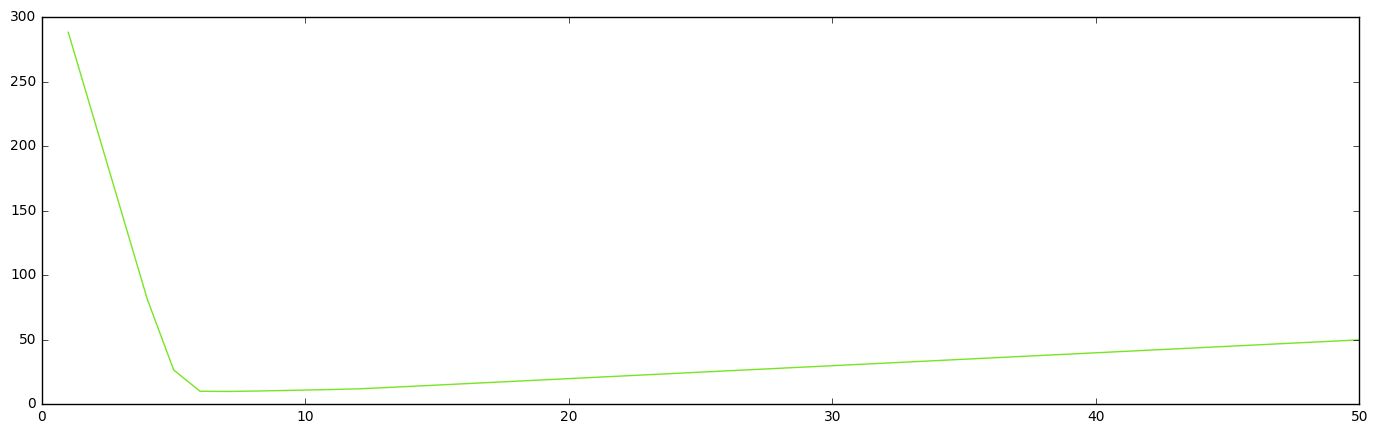

  0%|          | 0/357 [00:00<?, ?it/s]

Минимум достигается при количестве операторов равном(это и будет равно мин числу операторов):  7
Стульев надо столько:  -2.26377784033
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
 ^^^^^^^^^^^^^^^^^^^^^^^^^NEW OFFICE NUMBER 2^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-

100%|██████████| 357/357 [00:01<00:00, 268.00it/s]


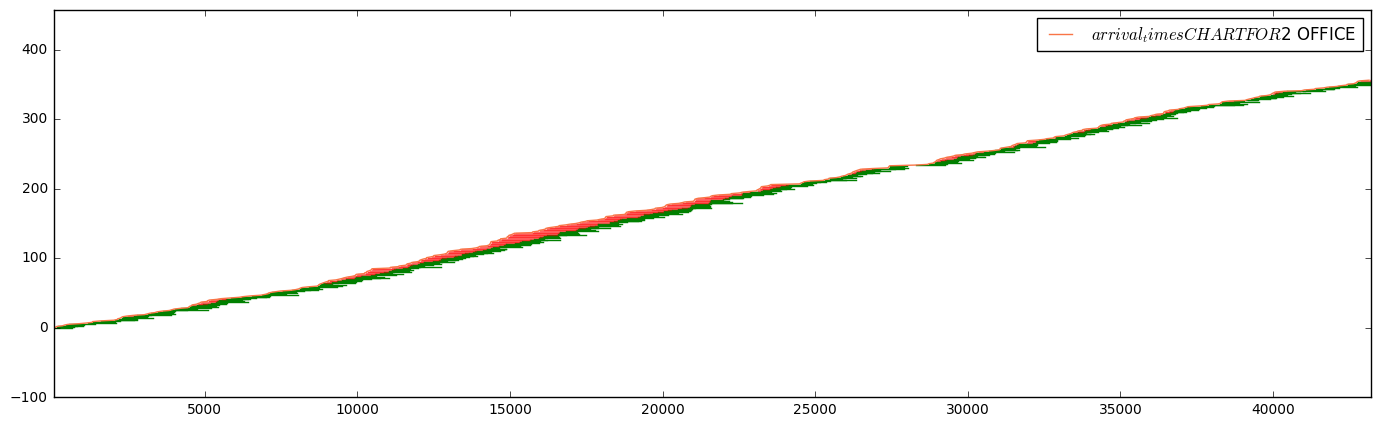

100%|██████████| 43158/43158 [00:03<00:00, 11519.69it/s]


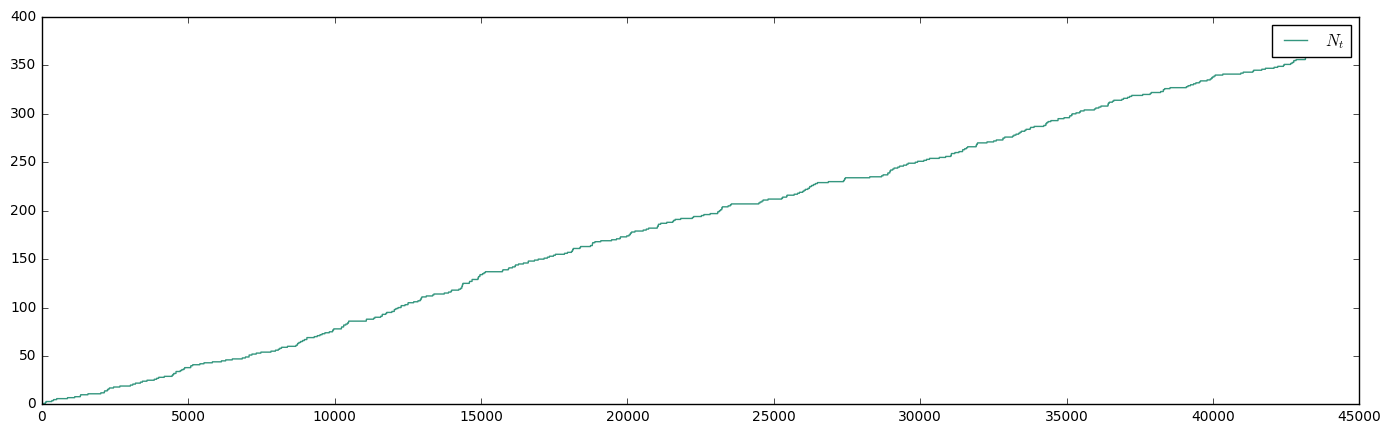

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


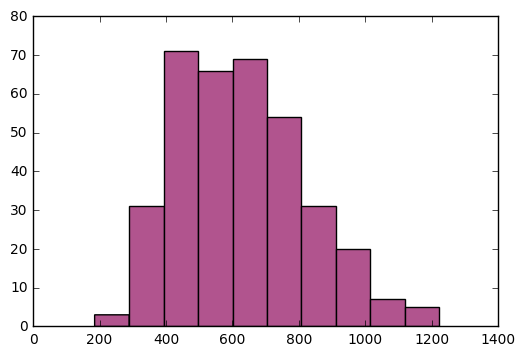

  1%|          | 417/43158 [00:00<00:10, 4163.14it/s]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
mean_service  628.459383754
fit results :  (9.5542297234340232, 35.425646101999121, 62.070281749902605)


100%|██████████| 43158/43158 [00:10<00:00, 4102.52it/s]


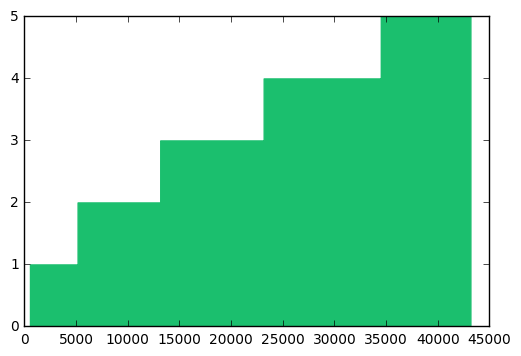

100%|██████████| 43158/43158 [00:00<00:00, 99623.76it/s] 


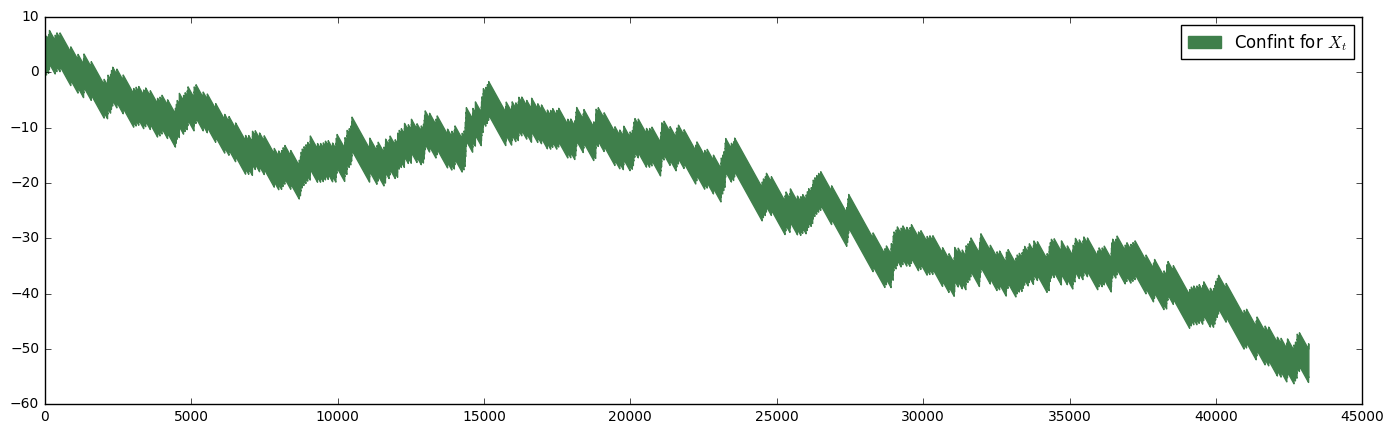

100%|██████████| 50/50 [00:00<00:00, 274.99it/s]


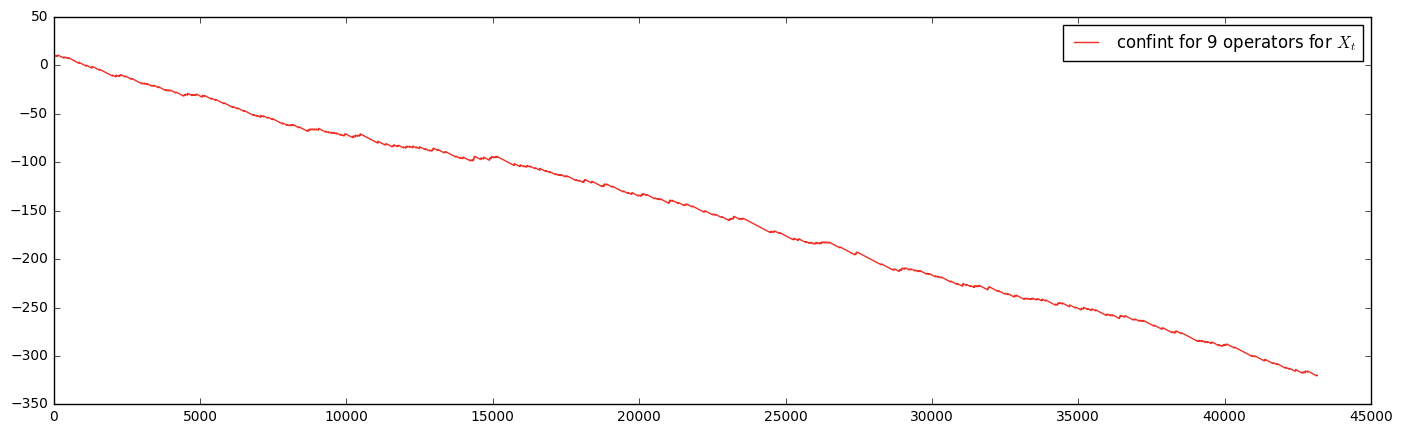

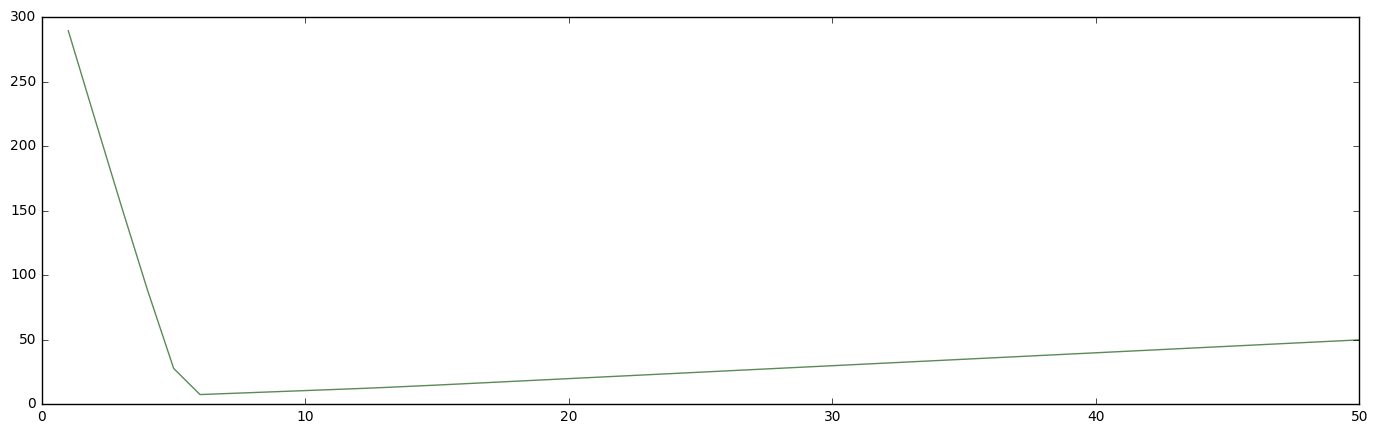

 12%|█▏        | 64/543 [00:00<00:01, 261.86it/s]

Минимум достигается при количестве операторов равном(это и будет равно мин числу операторов):  6
Стульев надо столько:  -0.461458816188
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
 ^^^^^^^^^^^^^^^^^^^^^^^^^NEW OFFICE NUMBER 3^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________

100%|██████████| 543/543 [00:01<00:00, 313.03it/s]


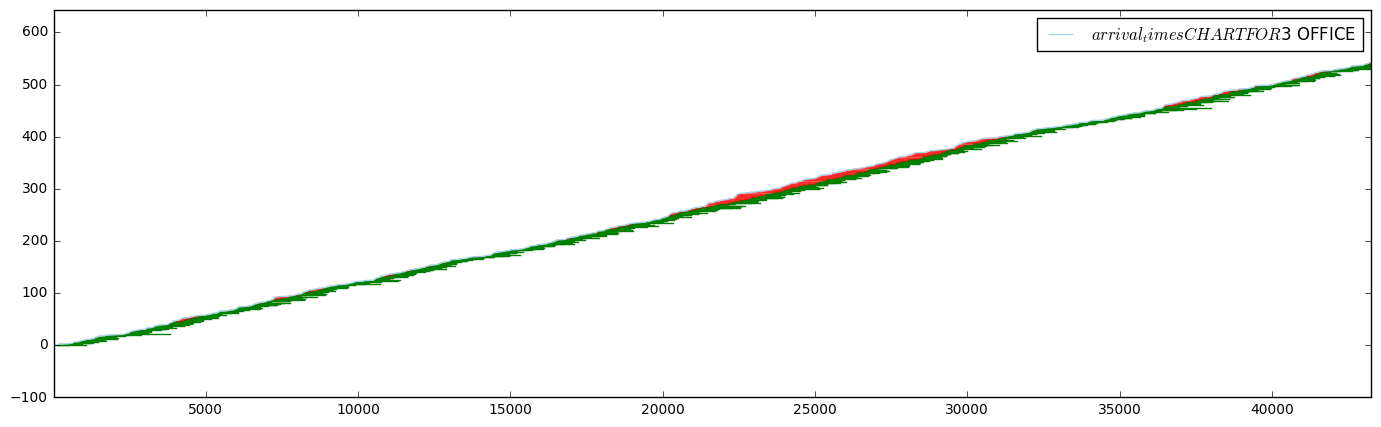

100%|██████████| 43208/43208 [00:05<00:00, 8177.10it/s]


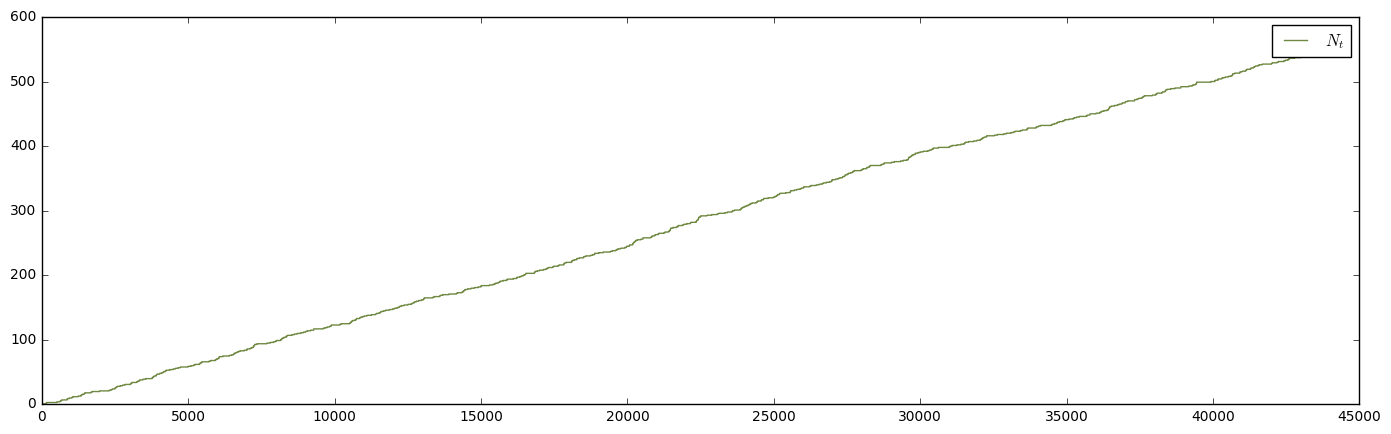

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


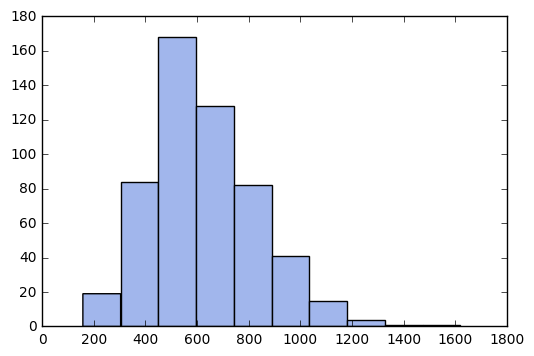

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.01 µs
mean_service  627.44198895


  2%|▏         | 944/43208 [00:00<00:08, 4736.03it/s]

fit results :  (8.9683275318068745, 9.7404390707189794, 68.875891045493773)


100%|██████████| 43208/43208 [00:10<00:00, 4276.08it/s]


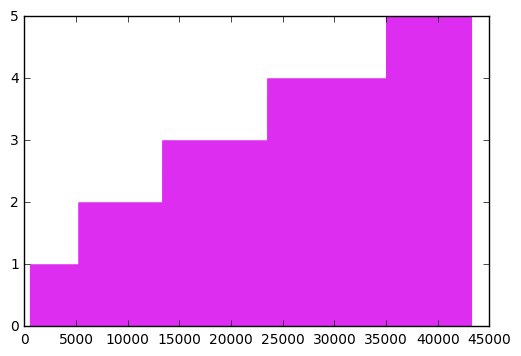

100%|██████████| 43208/43208 [00:00<00:00, 102240.60it/s]


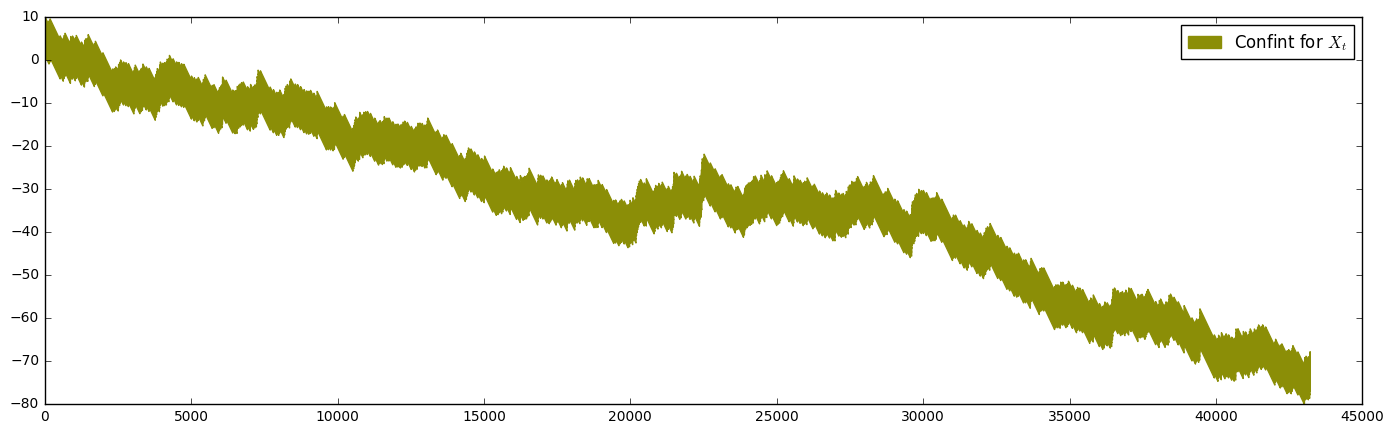

100%|██████████| 50/50 [00:00<00:00, 271.79it/s]


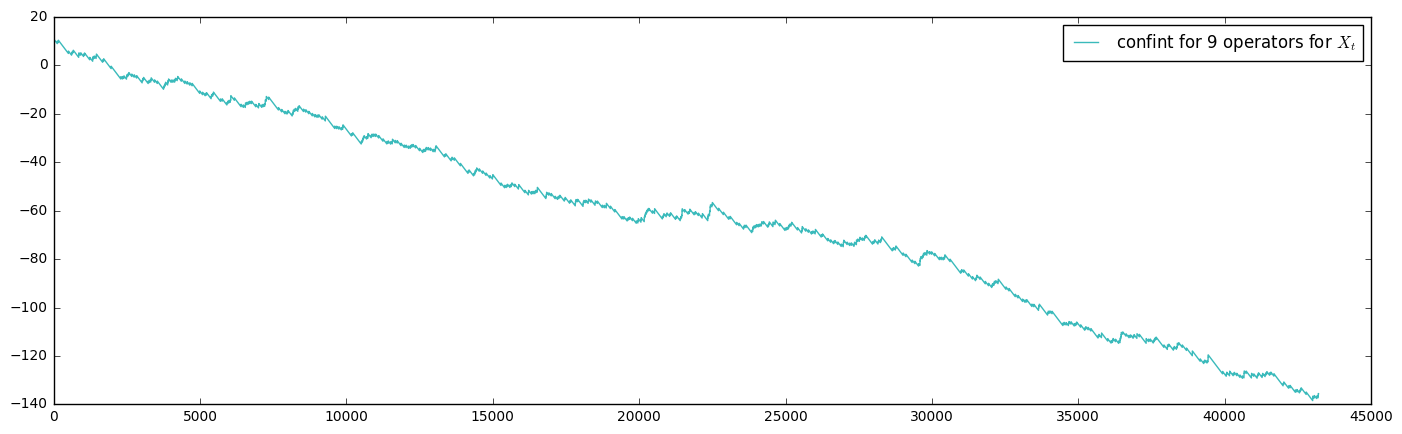

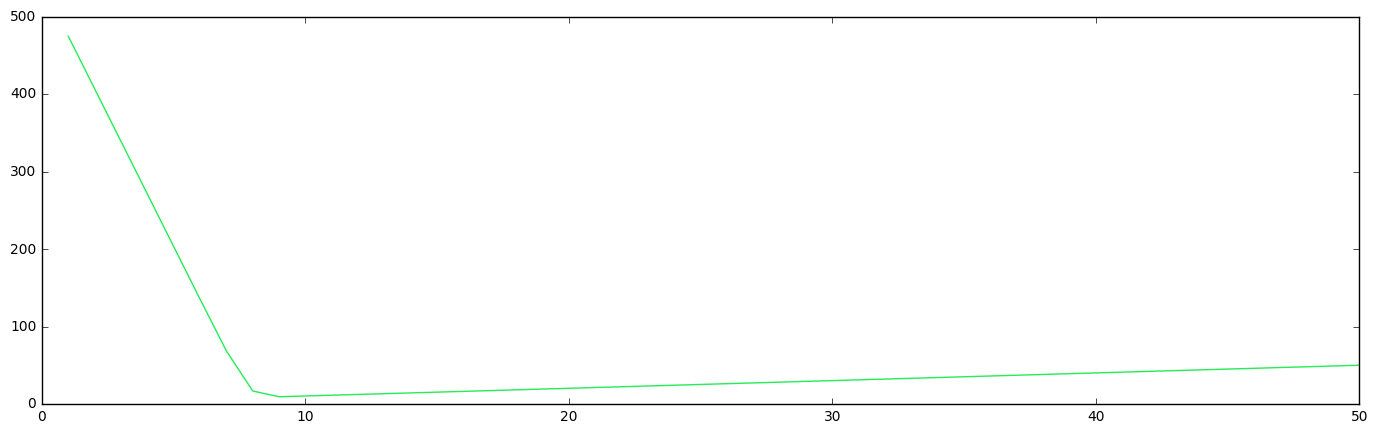

  0%|          | 0/606 [00:00<?, ?it/s]

Минимум достигается при количестве операторов равном(это и будет равно мин числу операторов):  9
Стульев надо столько:  0.266742979915
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
 ^^^^^^^^^^^^^^^^^^^^^^^^^NEW OFFICE NUMBER 4^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-

100%|██████████| 606/606 [00:02<00:00, 260.02it/s]


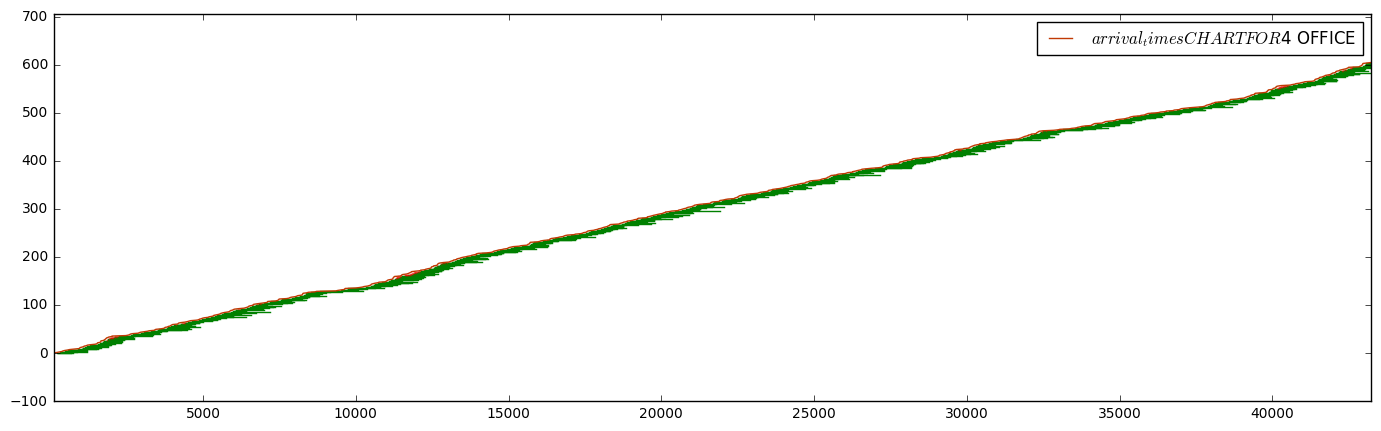

100%|██████████| 43239/43239 [00:05<00:00, 7611.46it/s]


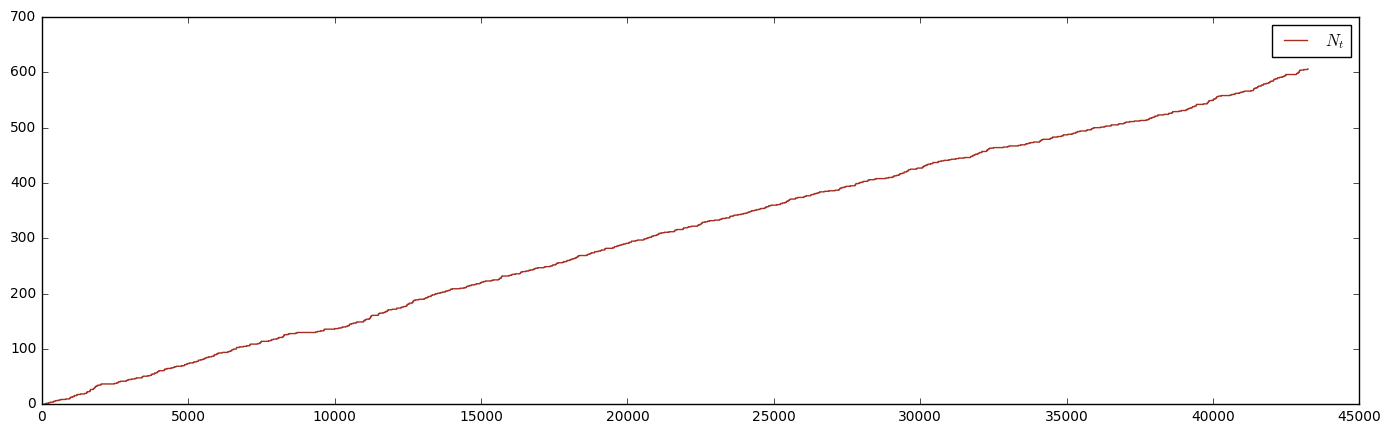

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


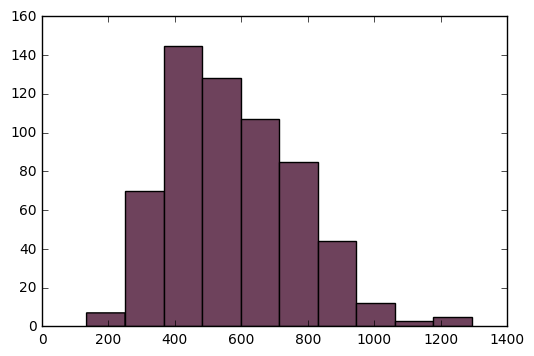

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.01 µs
mean_service  577.589108911


  2%|▏         | 829/43239 [00:00<00:10, 4163.96it/s]

fit results :  (9.3024821693126754, -2.4239204864676696, 62.35035197611333)


100%|██████████| 43239/43239 [00:10<00:00, 4143.82it/s]


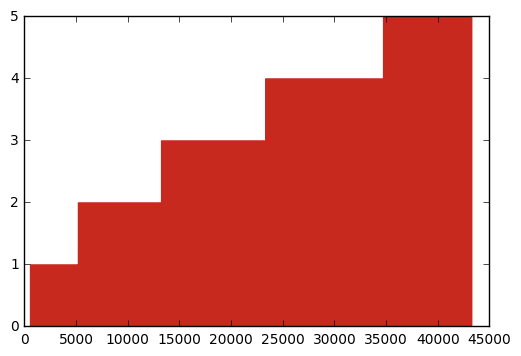

100%|██████████| 43239/43239 [00:00<00:00, 101087.82it/s]


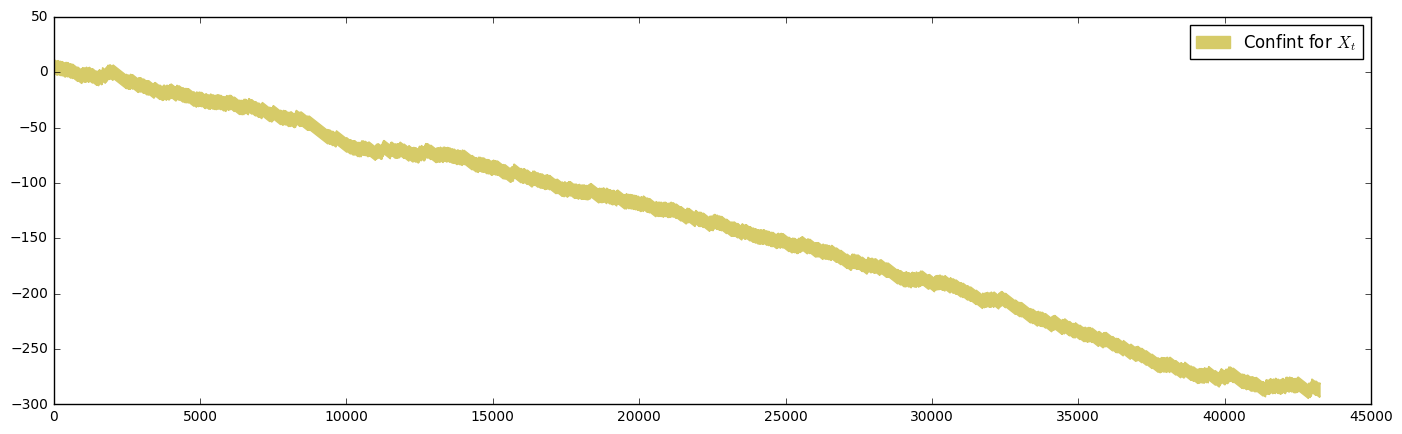

100%|██████████| 50/50 [00:00<00:00, 277.23it/s]


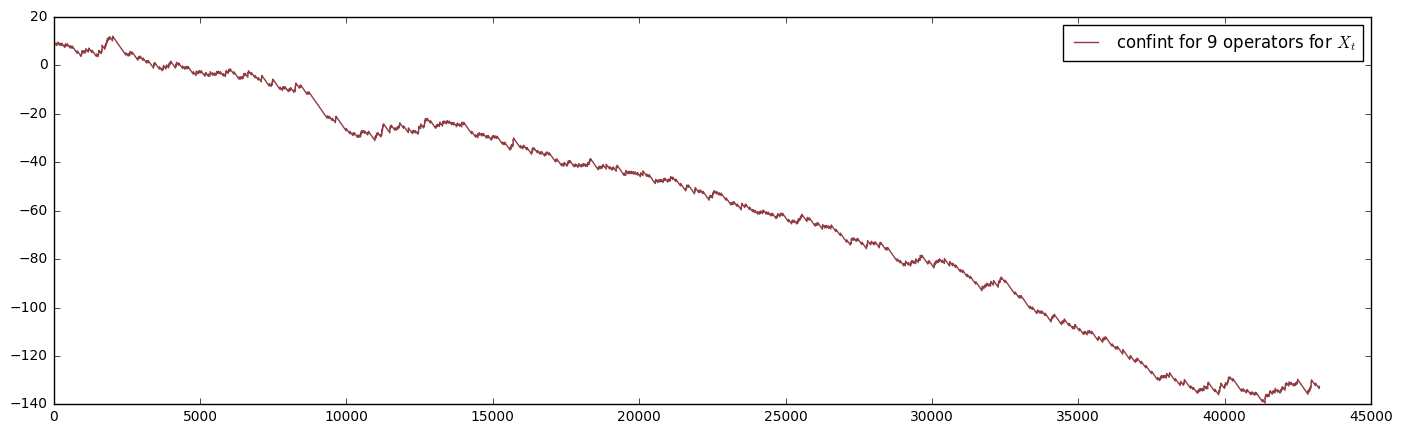

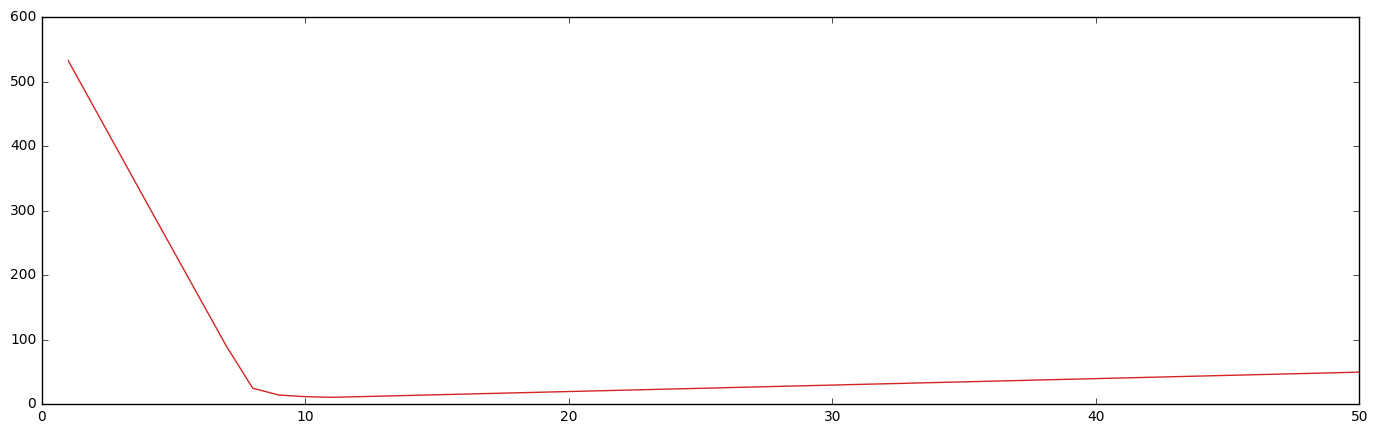

Минимум достигается при количестве операторов равном(это и будет равно мин числу операторов):  11
Стульев надо столько:  1.5013319277
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
 ^^^^^^^^^^^^^^^^^^^^^^^^^NEW OFFICE NUMBER 5^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^-------------------___________________________-------------------------___________________-------------
-------------------___________________________-------------------------___________________-------------
-------------------___________________________--

In [202]:
results = []
for i in (range(len(operators_number))):
    results.append(make_all(i))
    print (
      '-------------------___________________________-------------------------___________________-------------\n'
    + '-------------------___________________________-------------------------___________________-------------\n'
    + '-------------------___________________________-------------------------___________________-------------\n'
    + '-------------------___________________________-------------------------___________________-------------\n'
    + '-------------------___________________________-------------------------___________________-------------\n'
    + ' ^^^^^^^^^^^^^^^^^^^^^^^^^NEW OFFICE NUMBER ' + str(i + 1) + '^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^'
    + '-------------------___________________________-------------------------___________________-------------\n'
    + '-------------------___________________________-------------------------___________________-------------\n'
    + '-------------------___________________________-------------------------___________________-------------\n'
    + '-------------------___________________________-------------------------___________________-------------\n'
    + '-------------------___________________________-------------------------___________________-------------\n')

In [142]:
# len(result_0)

5

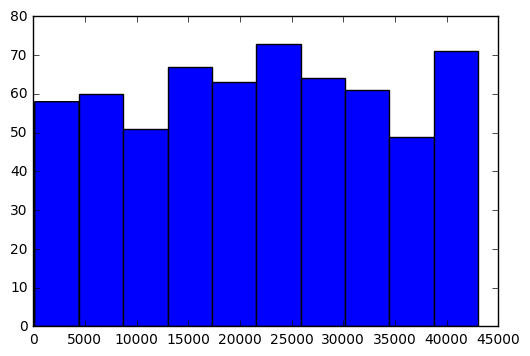

In [196]:
# plt.hist(data['arrival_times'])
# plt.show()

In [190]:
# quantiles_095 = []
# for elem in tqdm(np.array(result_0[1])[:,1]):
#     quantiles_095.append(np.percentile(elem ,95))

100%|██████████| 43072/43072 [00:03<00:00, 13819.96it/s]


In [191]:
# quantiles_095

[9.0,
 8.9854807586715406,
 8.9709615173430812,
 8.9564422760146218,
 8.9419230346861625,
 8.9274037933577031,
 8.9128845520292437,
 8.8983653107007825,
 8.8838460693723231,
 8.8693268280438637,
 8.8548075867154044,
 8.840288345386945,
 8.8257691040584856,
 8.8112498627300262,
 8.7967306214015668,
 8.7822113800731074,
 8.7676921387446463,
 8.7531728974161869,
 8.7386536560877275,
 8.7241344147592681,
 8.7096151734308087,
 8.6950959321023493,
 8.6805766907738899,
 8.6660574494454305,
 8.6515382081169712,
 8.63701896678851,
 8.6224997254600506,
 8.6079804841315912,
 8.5934612428031318,
 8.5789420014746725,
 8.5644227601462131,
 8.5499035188177537,
 8.5353842774892943,
 8.5208650361608331,
 8.5063457948323737,
 8.4918265535039144,
 8.477307312175455,
 8.4627880708469956,
 8.4482688295185362,
 8.4337495881900768,
 8.4192303468616174,
 8.404711105533158,
 8.3901918642046969,
 8.3756726228762375,
 8.3611533815477781,
 8.3466341402193187,
 8.3321148988908593,
 8.3175956575623999,
 8.303076416

In [189]:
# result_0[1]

[[0.0, 9.0],
 [-0.014519241328459595, 8.9854807586715406],
 [-0.02903848265691919, 8.9709615173430812],
 [-0.043557723985378785, 8.9564422760146218],
 [-0.05807696531383838, 8.9419230346861625],
 [-0.072596206642297975, 8.9274037933577031],
 [-0.08711544797075757, 8.9128845520292437],
 [-0.10163468929921717, 8.8983653107007825],
 [-0.11615393062767676, 8.8838460693723231],
 [-0.13067317195613634, 8.8693268280438637],
 [-0.14519241328459595, 8.8548075867154044],
 [-0.15971165461305553, 8.840288345386945],
 [-0.17423089594151514, 8.8257691040584856],
 [-0.18875013726997472, 8.8112498627300262],
 [-0.20326937859843433, 8.7967306214015668],
 [-0.21778861992689391, 8.7822113800731074],
 [-0.23230786125535352, 8.7676921387446463],
 [-0.2468271025838131, 8.7531728974161869],
 [-0.26134634391227268, 8.7386536560877275],
 [-0.27586558524073229, 8.7241344147592681],
 [-0.2903848265691919, 8.7096151734308087],
 [-0.30490406789765151, 8.6950959321023493],
 [-0.31942330922611106, 8.6805766907738899

In [194]:
# np.max(np.array(X_t_confint_with_N_t)[:,1])

16.998250788321855

In [195]:
# np.percentile(np.array(X_t_confint_with_N_t)[:,1], 95)

10.540892333275815

In [192]:
# np.argmax(abs(np.array(quantiles_095)))

31751

In [193]:
# quantiles_095[31751]

-0.00043141992063056023

In [188]:
# quantiles_095

[507.9768958944511,
 442.95379178890227,
 377.93068768335348,
 312.90758357780464,
 247.79553637262131,
 182.52260483504071,
 117.37577420265761,
 59.535009595824903,
 10.540892333275815,
 3.2182328517118206,
 0.92020810128170683,
 -1.4479480099775655,
 -3.818205005516945,
 -6.2479218633157219,
 -8.7327843841676973,
 -11.207977085065568,
 -13.795827515701092,
 -16.401277787364904,
 -19.007964534667941,
 -21.48424925089823,
 -23.958461713443143,
 -26.432674175988055,
 -28.906886638532971,
 -31.381099101077872,
 -33.855311563622784,
 -36.329524026167689,
 -38.803736488712602,
 -41.277948951257521,
 -43.752161413802433,
 -46.226373876347346,
 -48.700586338892258,
 -51.17479880143717,
 -53.649011263982082,
 -56.123223726526994,
 -58.5974361890719,
 -61.071648651616819,
 -63.545861114161724,
 -66.020073576706636,
 -68.494286039251548,
 -70.968498501796461,
 -73.442710964341359,
 -75.916923426886285,
 -78.391135889431212,
 -80.86534835197611,
 -83.339560814521036,
 -85.813773277065934,
 -88.

In [119]:
# office_number = 0
# data = pd.read_csv('/Users/semenfedotov/Desktop/Slupy/data/office_' + str(office_number), sep='\t')
# data.head()
# data = data.apply(lambda x: x - UNIX_TIME)
# data.head()


In [120]:
# len(data)

In [7]:
# bounds = [np.min(data['arrival_times']), np.max(data['start_service_time'])]
# bounds

[152, 44204]

In [121]:
# plt.figure(figsize=(17,5))
# for i in tqdm(range(len(data))):
#     elem = data.iloc[i]
#     plt.axhline(y=i, xmin=elem[0] / (bounds[1] - bounds[0]), xmax=elem[1] / (bounds[1] - bounds[0]), hold=None, color='red', alpha=0.5)
#     plt.axhline(y=i, xmin=elem[1] / (bounds[1] - bounds[0]), xmax=elem[2] / (bounds[1] - bounds[0]), hold=None, color='green')
# plt.xlim(bounds[0], bounds[1])
# plt.ylim(-100, len(data) + 100)
# plt.plot(data['arrival_times'], range(len(data)), color=color_generator(), label='$arrival_times$')
# plt.legend(['waiting time','service time'])
# plt.legend()
# plt.show()

In [9]:
# lambda_cup = 1 / np.mean(data['arrival_times'])
# lambda_cup

4.5433458760115755e-05

In [19]:
# arrival_time_max = np.max(data['arrival_times'])
# arrival_time_max

43062

In [21]:
# times_linspace = np.arange(0,arrival_time_max + 10, 1)
# N_t = []
# for time in tqdm(times_linspace):
#     N_t.append(np.sum([arr_time <= time for arr_time in data['arrival_times']]))

100%|██████████| 43072/43072 [00:05<00:00, 7269.48it/s]


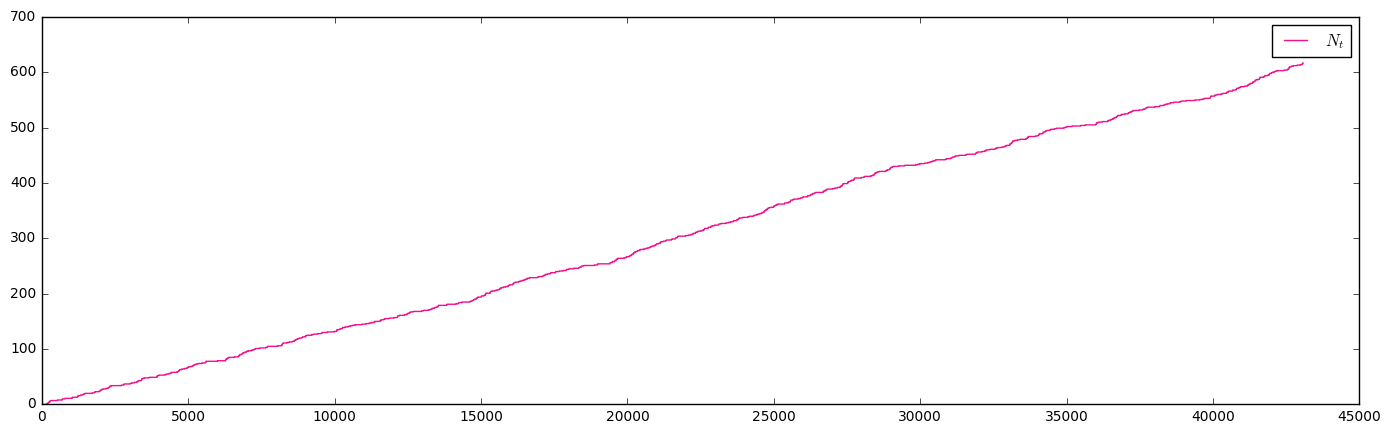

In [37]:
# plt.figure(figsize=(17,5))
# plt.plot(times_linspace, N_t, color=color_generator(), label='$N_t$')
# plt.legend()
# plt.show()

In [38]:
# %%time
# service_times = list(map(lambda ind: data['end_service_time'][ind] - data['start_service_time'][ind], range(len(data))))

CPU times: user 21.4 ms, sys: 522 µs, total: 21.9 ms
Wall time: 22 ms


In [39]:
# len(service_times)

617

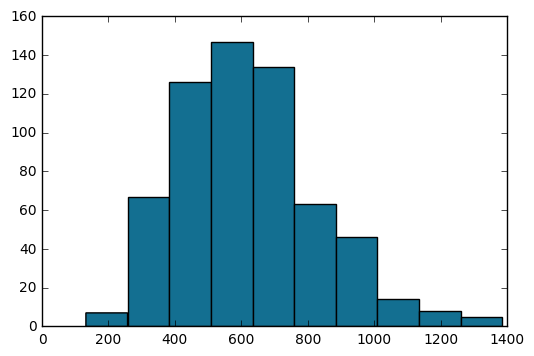

CPU times: user 259 ms, sys: 9.75 ms, total: 268 ms
Wall time: 265 ms


In [42]:
# %%time
# plt.hist(service_times, color=color_generator())
# plt.show()

In [41]:
# %%time
# mean_service_time = np.mean(service_times)
# print(mean_service_time)

619.867098865
CPU times: user 492 µs, sys: 40 µs, total: 532 µs
Wall time: 521 µs


# Гистограмма похожа на график плотности Гамма распределения. Узнаем параметры его с помощью ОМП, есть встроенная метод .fit

In [43]:
# fit_results = sps.gamma.fit(service_times)
# fit_results

(8.3952299708195852, 10.879402100506228, 72.539728692237247)

In [44]:
# my_dist = sps.gamma(fit_results[0], fit_results[1], fit_results[2])
# my_sample = my_dist.rvs(len(service_times))


In [45]:
# my_sample = my_dist.rvs(len(service_times))
# my_sample

array([  384.41790355,   577.2824182 ,   318.8422412 ,  1120.99094004,
         495.93208289,   866.34164772,   632.59723966,   718.85191924,
         711.09777953,   603.09672313,   917.08594063,   684.6679842 ,
         677.17243998,   504.16603853,   699.09684916,   643.68832964,
         624.02760721,   553.22899676,   422.04201058,   636.58586376,
        1207.39518423,   690.53412341,   353.275672  ,   989.88257365,
         525.61827834,   400.23006599,   649.12703831,   282.49485795,
         847.97008619,   415.50059546,   579.73900158,   565.36817411,
         512.85247292,   518.00987771,   467.54059917,   386.87703089,
         468.03959572,   498.59488628,   312.71231989,   478.1357107 ,
         579.31743041,   629.4738557 ,   825.81525712,   629.85517614,
         492.28541722,   396.43680563,   584.07393118,   737.5506628 ,
         391.20423982,   466.30179608,   568.49470174,   959.94117557,
         645.74559386,   903.80286578,   579.48021776,   901.894986  ,
      

In [21]:
# sps.chisquare(list(counter_st.values()), predicted_probs * len(service_times))

Power_divergenceResult(statistic=6.464906741525834e+150, pvalue=0.0)

# SECOND...TASK

при заданном количестве операторов. Для этого
сначала постройте доверительные интервалы (в т.ч. их графики) для процесса $N_t$
для каждого момента времени. Это будет просто-напросто отрезок между двумя квантилями
Так как наш процесс пуассоновский, то $N_t \sim Pois(\lambda t)$ Возьмем тогда $\frac{1 - \alpha}{2} $ u $\frac{1 + \alpha}{2}$ квантили этого распределния

In [46]:
# data['arrival_times']

0        152
1        204
2        207
3        217
4        258
5        278
6        282
7        523
8        695
9        701
10       787
11      1026
12      1042
13      1213
14      1221
15      1241
16      1318
17      1388
18      1429
19      1460
20      1719
21      1800
22      1808
23      1951
24      1986
25      2003
26      2036
27      2077
28      2191
29      2250
       ...  
587    41584
588    41586
589    41602
590    41604
591    41718
592    41762
593    41764
594    41873
595    41913
596    41926
597    41938
598    41992
599    42018
600    42082
601    42117
602    42179
603    42427
604    42533
605    42560
606    42580
607    42588
608    42607
609    42615
610    42673
611    42734
612    42870
613    42983
614    43039
615    43061
616    43062
Name: arrival_times, dtype: int64

In [124]:
# alpha = 1 - 0.05
# confint_bounds = []
# for time in tqdm(times_linspace):
#     left = sps.poisson.ppf((1 - alpha) / 2., lambda_cup * time)
#     right = sps.poisson.ppf((1 + alpha) / 2., lambda_cup * time)
#     confint_bounds.append([left, right])

100%|██████████| 43072/43072 [00:10<00:00, 4185.92it/s]


In [125]:
# confint_min_max = [np.min(np.array(confint_bounds)[:,0]), np.max(np.array(confint_bounds)[:,1])]
# confints_axis_len = confint_min_max[1] - confint_min_max[0]
# confint_min_max

[0.0, 5.0]

In [126]:
# confint_bounds

[[0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],

617it [00:01, 417.48it/s]


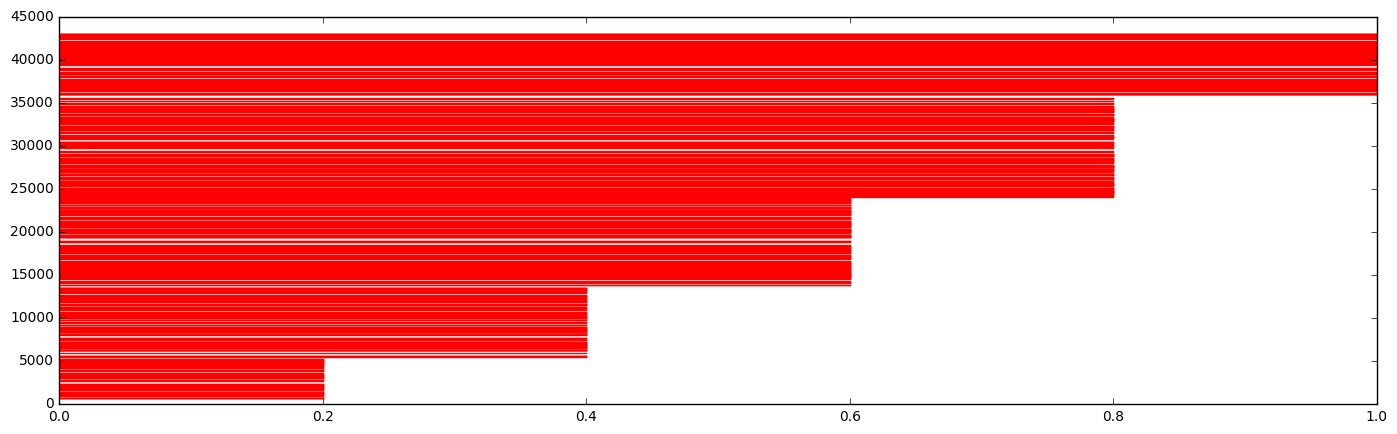

In [34]:
# plt.figure(figsize=(17,5))
# for t_ind, c_int in tqdm(enumerate(confint_bounds)):
#     plt.axhline(y=data['arrival_times'][t_ind], xmin=c_int[0] / confints_axis_len, xmax=c_int[1] / confints_axis_len, color='r')
# plt.show()

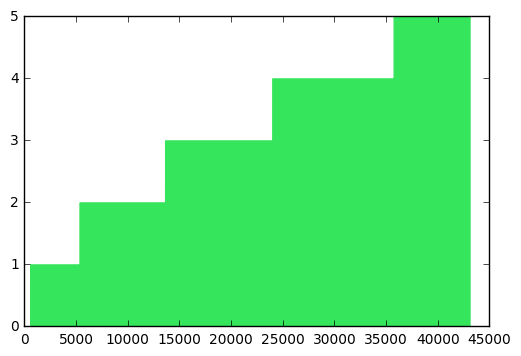

In [127]:
# plt.fill_between(times_linspace, np.array(confint_bounds)[:,0], np.array(confint_bounds)[:,1], color = color_generator())

In [51]:
# m_grid = range(1, 501)
# X_t_confint_m = []
# for  m in tqdm(m_grid):
#     level_m = []
#     for t_ind, c_int in (enumerate(confint_bounds)):
#         level_m.append(c_int[1] - m * (data['arrival_times'][t_ind] - mean_service_time) / mean_service_time)
#     X_t_confint_m.append(level_m)

100%|██████████| 500/500 [00:06<00:00, 73.37it/s]


In [37]:
# maxes_for_m = [np.max(X_t_confint_m[i]) for i in range(len(X_t_confint_m))]

In [129]:
# maxes_for_m

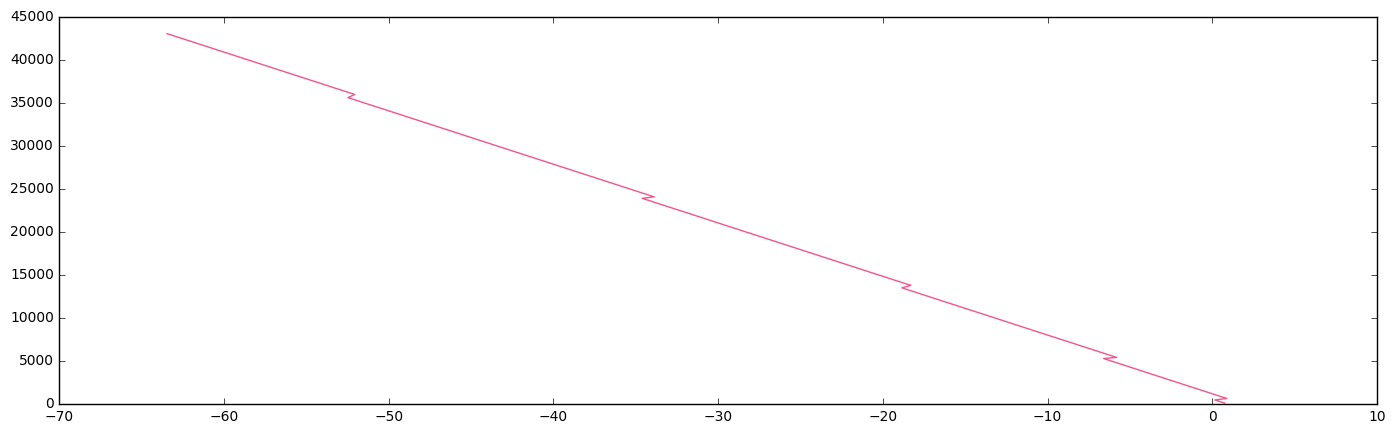

In [39]:
# plt.figure(figsize=(17,5))
# plt.plot(X_t_confint_m[0], data['arrival_times'],color=color_generator())
# plt.show()

In [55]:
# X_t_confint = []
# for t_ind, c_int in tqdm(enumerate(confint_bounds)):
#     X_t_confint.append([max(0, c_int[0] - operators_number[office_number] * data['arrival_times'][t_ind] / mean_service_time),
#                         c_int[1] - operators_number[office_number] * (data['arrival_times'][t_ind] - mean_service_time) / mean_service_time ])

617it [00:00, 20957.93it/s]


In [56]:
# X_t_confint_min_max = [np.min(np.array(X_t_confint)[:,0]), np.max(np.array(X_t_confint)[:,1])]
# X_t_confints_axis_len = X_t_confint_min_max[1] - X_t_confint_min_max[0]
# X_t_confint_min_max

[0.0, 6.7930753180741421]

In [60]:
# X_t_confints_axis_len

6.7930753180741421

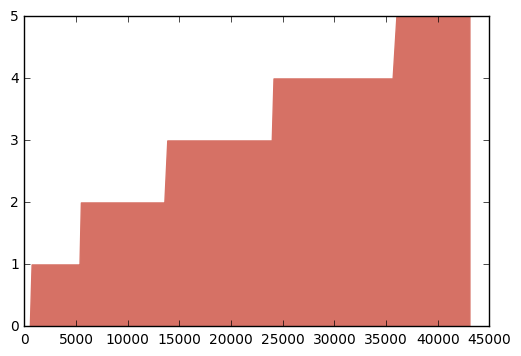

In [57]:
# plt.fill_between(data['arrival_times'], np.array(confint_bounds)[:,0], np.array(confint_bounds)[:,1], color = color_generator())

In [58]:
# X_t_confints_axis_len

6.7930753180741421

617it [00:01, 468.59it/s]


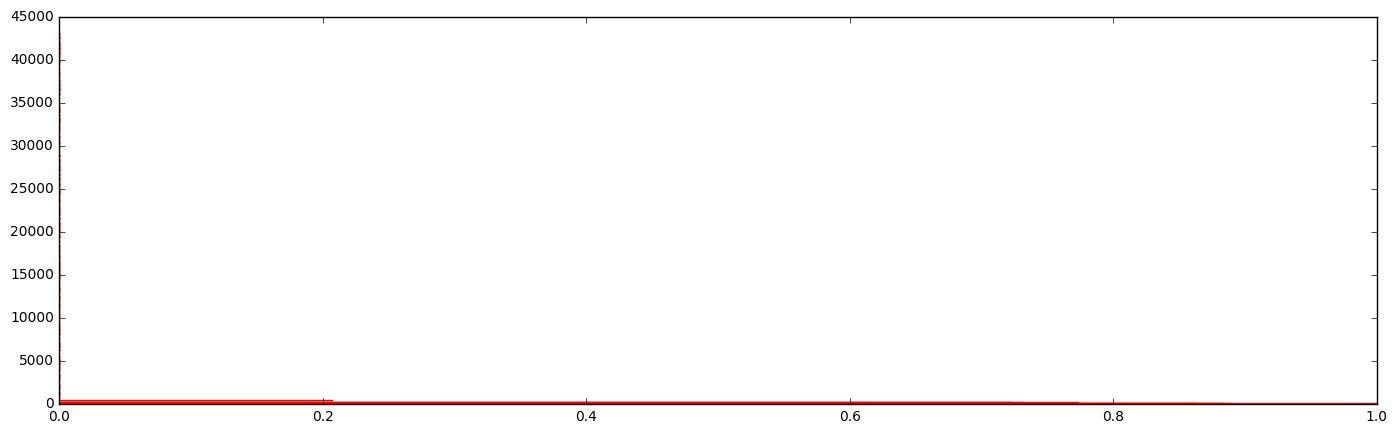

In [59]:
# plt.figure(figsize=(17,5))
# for t_ind, c_int in tqdm(enumerate(X_t_confint)):
#     plt.axhline(y=data['arrival_times'][t_ind], xmin=(c_int[0] - X_t_confint_min_max[0]) / X_t_confints_axis_len, xmax=(c_int[1] - X_t_confint_min_max[0]) / X_t_confints_axis_len, color='r')
# plt.show()

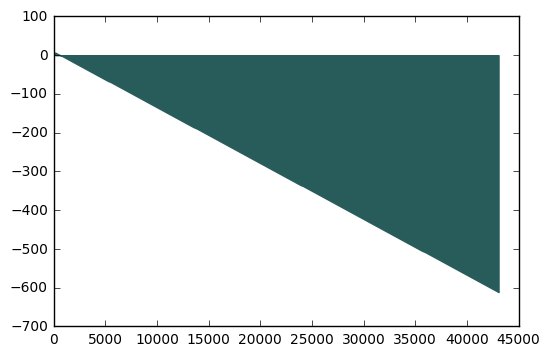

In [61]:
# plt.fill_between(data['arrival_times'], np.array(X_t_confint)[:,0], np.array(X_t_confint)[:,1], color = color_generator())

# А теперь нарисуем просто то нер-во, которое есть в условии

In [63]:
# X_t_confint_with_N_t = []
# for time in tqdm(times_linspace):
#     X_t_confint_with_N_t.append([N_t[time] - operators_number[office_number] * time / mean_service_time,
#                         N_t[time] - operators_number[office_number] * (time - mean_service_time) / mean_service_time ])
# X_t_confint_with_N_t_min_max = [np.min(np.array(X_t_confint_with_N_t)[:,0]), np.max(np.array(X_t_confint_with_N_t)[:,1])]
# X_t_confints_with_N_t_axis_len = X_t_confint_min_max[1] - X_t_confint_min_max[0]
# X_t_confint_with_N_t_min_max



100%|██████████| 43072/43072 [00:00<00:00, 77309.66it/s]


[-27.7168394961015, 16.998250788321855]

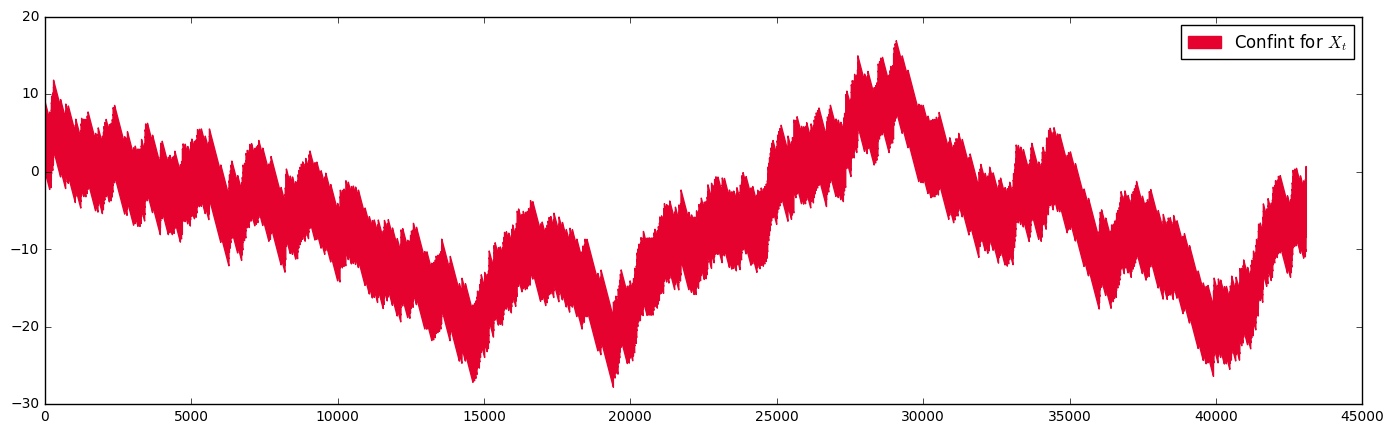

In [74]:
# plt.figure(figsize=(17,5))
# plt.fill_between(times_linspace, np.array(X_t_confint_with_N_t)[:,0], np.array(X_t_confint_with_N_t)[:,1], color = color_generator(), label='Confint for $X_t$')
# plt.legend()
# plt.show()

M_GRID

In [76]:
# m_grid = range(1, 501)
# X_t_N_t_confint_m = []
# for  m in tqdm(m_grid):
#     level_m = []
#     for time in (times_linspace):
#         level_m.append(N_t[time] - m * (time - mean_service_time) / mean_service_time)
#     X_t_N_t_confint_m.append(level_m)

100%|██████████| 500/500 [01:36<00:00,  5.46it/s]


In [101]:
# cool_ms = []
# max_of_waiting_persons = []
# for m in tqdm(m_grid):
#     max_of_waiting_persons.append(np.max(X_t_N_t_confint_m[m - 1]))
#     if X_t_N_t_confint_m[m - 1][-20] >= X_t_N_t_confint_m[m - 1][-1]:
#         cool_ms.append(m)

100%|██████████| 500/500 [00:02<00:00, 217.22it/s]


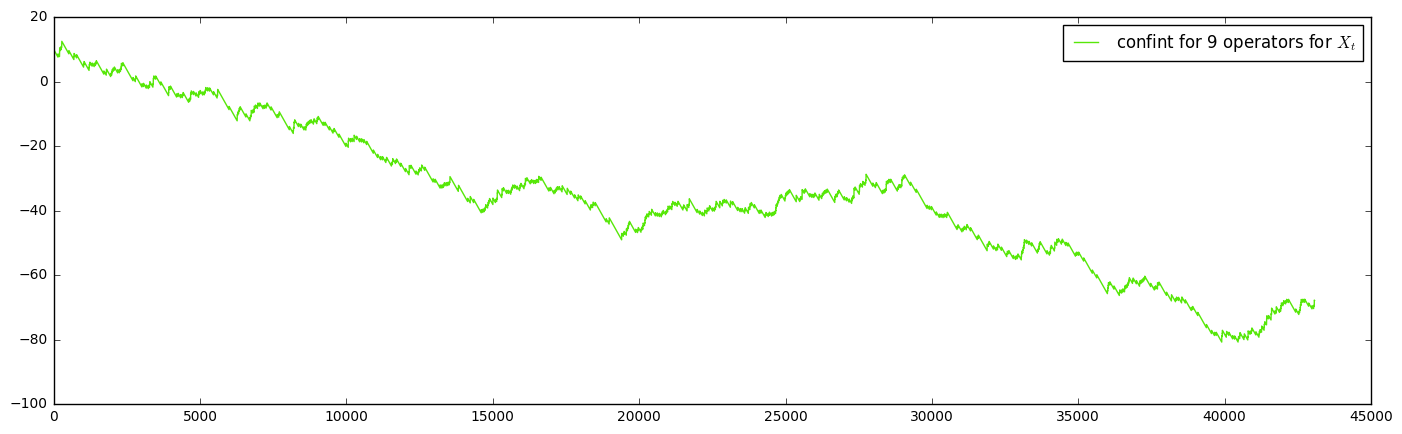

In [105]:
# plt.figure(figsize=(17,5))
# plt.plot(times_linspace, X_t_N_t_confint_m[9], color=color_generator(),label='confint for 9 operators for $X_t$')
# plt.legend()
# plt.show()

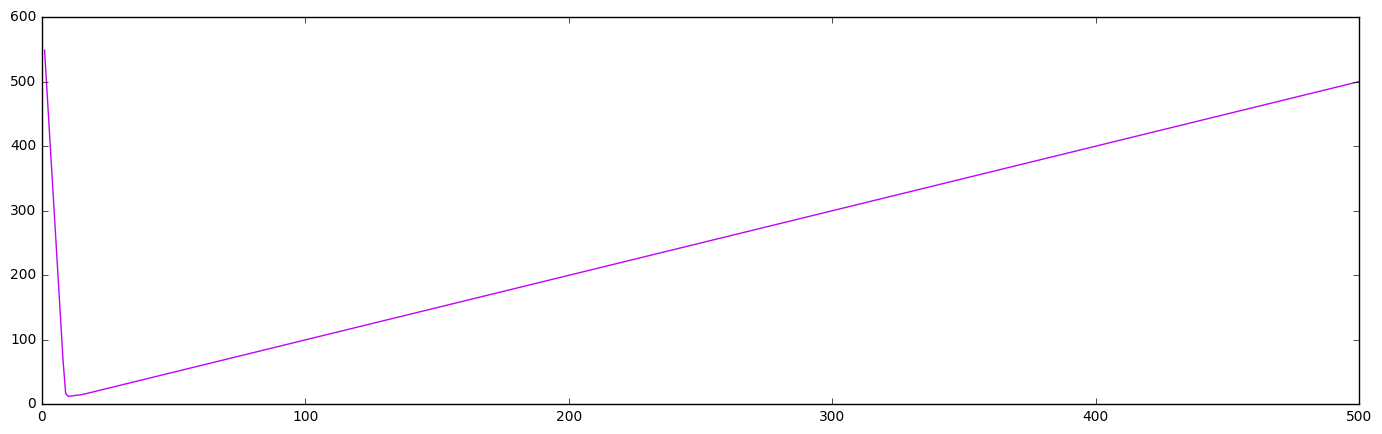

In [108]:
# plt.figure(figsize=(17,5))
# plt.plot(m_grid, max_of_waiting_persons, color=color_generator())
# plt.show()

In [113]:
# print( "Минимум достигается при количестве операторов равном: ", np.argmin(max_of_waiting_persons) + 1)

Минимум достигается при количестве операторов равном:  10


Дайте ответы на следующие вопросы. Какое минимальное количество
операторов нужно каждому отделению банка, чтобы в нем не накапливалась боль-
шая очередь? Если их больше, чем это минимальное количество, в какие отделения
вы бы отдали ”лишних” операторов? Если их меньше, то сколько операторов вам
нужно нанять и в какие отделения? Сколько стульев нужно поставить в каждое от-
деление банка, чтобы с большой вероятностью ни одному из ожидающих клиентов
не пришлось стоять?

# 3 ТАСК